# NỘI DUNG ĐỀ TÀI

### Sử dụng Hierarchical Clustering Dự báo xu hướng giá vàng, Phát hiện các mô hình trong quá khứ có thể lặp lại trong tương lai.
* Hỗ trợ đầu tư: Giúp nhà đầu tư phân loại giai đoạn thị trường và đưa ra chiến lược phù hợp.
* Phân tích tác động kinh tế: Xác định ảnh hưởng của các chỉ số tài chính đến giá vàng.

Trong dự án này, chúng tôi sử dụng hàm linkage thực hiện phân cụm phân cấp với phường thức là Euclidean Distance giúp xác định khoảng cách giữa các cụm.

### Chuẩn bị dữ liệu
* Dữ liệu giá vàng được tải từ Yahoo Finance (GLD), quy đổi sang VND/lượng.
* Tính hai đặc trưng: Daily_Change (% thay đổi giá hàng ngày) và Volatility (độ lệch chuẩn 7 ngày).


# Chuẩn bị thư viện và thiết lập dữ liệu

In [95]:
# Import các thư viện cần thiết
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score


In [103]:
# Tải dữ liệu giá vàng từ Yahoo Finance (GLD - SPDR Gold Shares)
ticker = "GLD"
data = yf.download(ticker, start="2020-01-01", end="2025-04-17")  # Từ 2020 đến hiện tại
print(data)
data = data[['Close']].reset_index()  # Chỉ lấy giá đóng cửa và cột Date
data.columns = ['Date', 'Gold_Price']


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker             GLD         GLD         GLD         GLD       GLD
Date                                                                
2020-01-02  143.949997  144.210007  143.399994  143.860001   7733800
2020-01-03  145.860001  146.320007  145.399994  145.750000  12272800
2020-01-06  147.389999  148.479996  146.949997  148.440002  14403300
2020-01-07  147.970001  148.139999  147.429993  147.570007   7978500
2020-01-08  146.860001  148.610001  146.139999  148.490005  22248500
...                ...         ...         ...         ...       ...
2025-04-10  292.350006  292.859985  287.230011  288.809998  19837800
2025-04-11  297.929993  299.269989  296.809998  297.959991  21080100
2025-04-14  296.230011  296.579987  294.529999  295.540009  12427600
2025-04-15  297.779999  298.019989  296.089996  296.929993   7924100
2025-04-16  307.470001  308.059998  303.799988  304.649994  20778100

[1330 rows x 5 columns]


- Trong đoạn code tôi cung cấp, dữ liệu giá vàng được lấy từ Yahoo Finance thông qua mã chứng khoán GLD (SPDR Gold Shares), một quỹ ETF phản ánh giá vàng trên thị trường quốc tế. Do đó, đơn vị giá vàng ở đây không phải là giá theo "chỉ" hay "lượng" theo cách tính ở Việt Nam, mà là giá theo USD trên mỗi cổ phiếu của GLD.
- GLD là một quỹ ETF (Exchange-Traded Fund) được niêm yết trên sàn NYSE, đại diện cho giá trị của vàng vật chất. Mỗi cổ phiếu GLD tương ứng với khoảng 1/10 ounce vàng (1 ounce = 31.1035 gram, theo chuẩn vàng quốc tế - troy ounce).
- Giá GLD thay đổi theo giá vàng trên thị trường quốc tế, được tính bằng USD/ounce, và giá cổ phiếu GLD phản ánh gần đúng giá vàng sau khi điều chỉnh chi phí quản lý quỹ.
- Đơn vị trong code
    + Trong code, cột Close từ yfinance trả về giá đóng cửa của GLD mỗi ngày, đơn vị là USD/cổ phiếu.
    + Ví dụ: Nếu ngày 03/04/2025, giá GLD là 200 USD/cổ phiếu, thì giá vàng quốc tế tương ứng khoảng 2000 USD/ounce (vì 1 cổ phiếu GLD ~ 1/10 ounce).

- Ở Việt Nam:
    + 1 chỉ = 3.75 gram.
    + 1 lượng = 10 chỉ = 37.5 gram.
    + Trong khi đó, 1 ounce = 31.1035 gram, nên 1 lượng Việt Nam ≈ 1.205 ounce.

- Nếu bạn muốn phân tích giá vàng theo VND/lượng thay vì USD/cổ phiếu GLD
    + Chuyển từ GLD sang USD/ounce
    + Chuyển từ USD/ounce sang VND/lượng

In [104]:
# Quy đổi sang USD/ounce và VND/lượng
data['Gold_Price_Ounce'] = data['Gold_Price'] * 10  # USD/ounce
exchange_rate = 25000  # Tỷ giá USD/VND (cập nhật theo ngày thực tế)
data['Gold_Price_VND_per_Luong'] = (data['Gold_Price_Ounce'] * exchange_rate) / 0.8294  # VND/lượng

In [105]:
# Tính đặc trưng: tỷ lệ thay đổi hàng ngày và biến động
data['Daily_Change'] = data['Gold_Price_VND_per_Luong'].pct_change() * 100  # % thay đổi
data['Volatility'] = data['Gold_Price_VND_per_Luong'].rolling(window=7).std()  # Biến động 7 ngày
data = data.dropna()  # Loại bỏ NaN

In [106]:
# Chuẩn bị dữ liệu cho clustering
X = data[['Daily_Change', 'Volatility']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

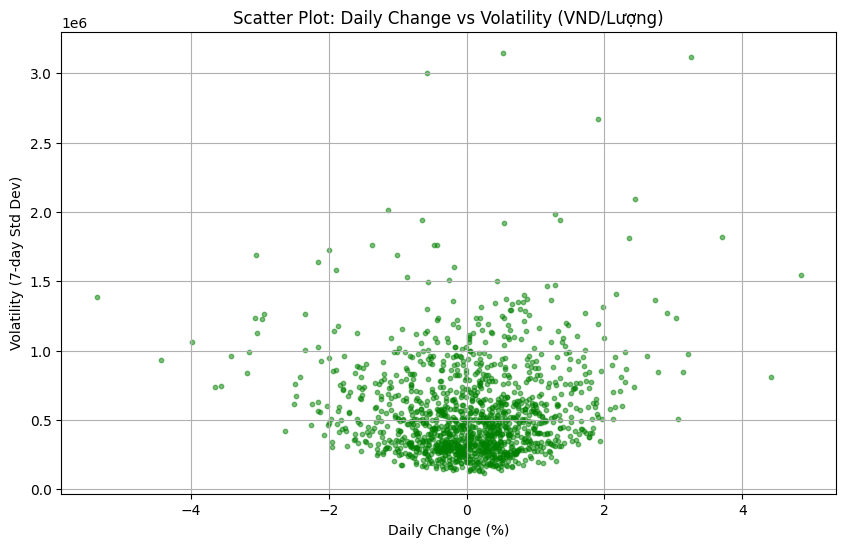

In [107]:
# 1. Vẽ scatter plot của Daily_Change và Volatility
plt.figure(figsize=(10, 6))
plt.scatter(data['Daily_Change'], data['Volatility'], s=10, c='green', alpha=0.5)
plt.title('Scatter Plot: Daily Change vs Volatility (VND/Lượng)')
plt.xlabel('Daily Change (%)')
plt.ylabel('Volatility (7-day Std Dev)')
plt.grid(True)
plt.show()

# Áp dụng Hierarchical Clustering bằng phương thức Euclidean Method

In [108]:
Z = linkage(X_scaled, method='average', metric='euclidean')

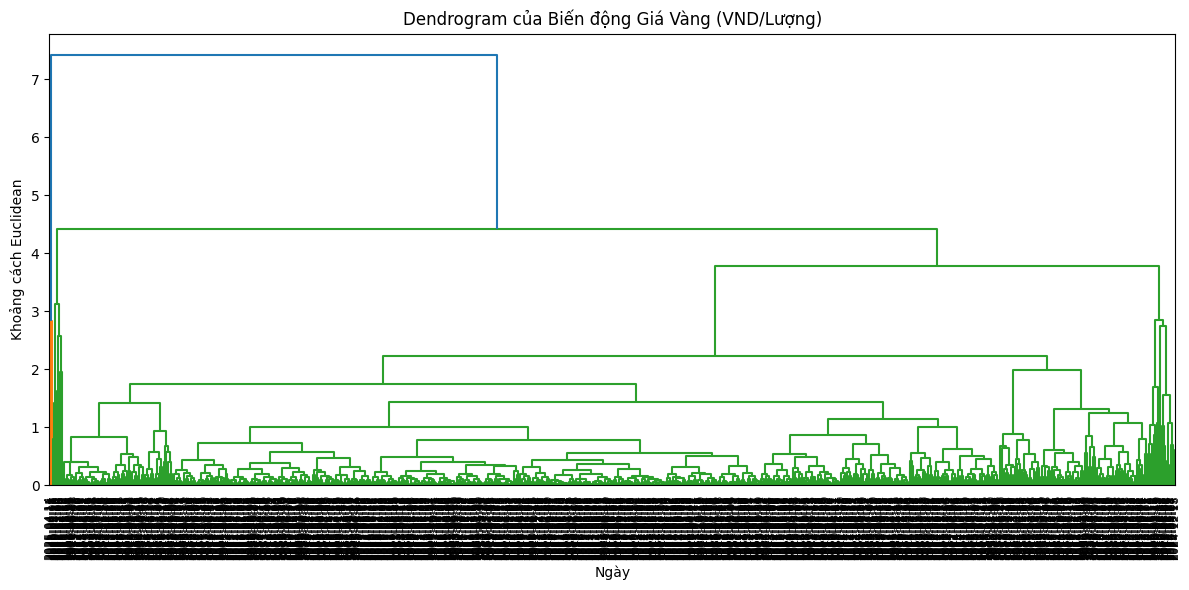

In [109]:
# Dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=data['Date'].dt.strftime('%Y-%m-%d').values, leaf_rotation=90, leaf_font_size=8)
plt.title('Dendrogram của Biến động Giá Vàng (VND/Lượng)')
plt.xlabel('Ngày')
plt.ylabel('Khoảng cách Euclidean')
plt.tight_layout()
plt.show()

In [112]:
# 3. Chia thành 3 cụm bằng hàm fcluster
num_hierarchical_clusters = 3  # Chọn số cụm
hierarchical_clusters = fcluster(Z, t=num_hierarchical_clusters, criterion='maxclust')
data['Cluster'] = hierarchical_clusters

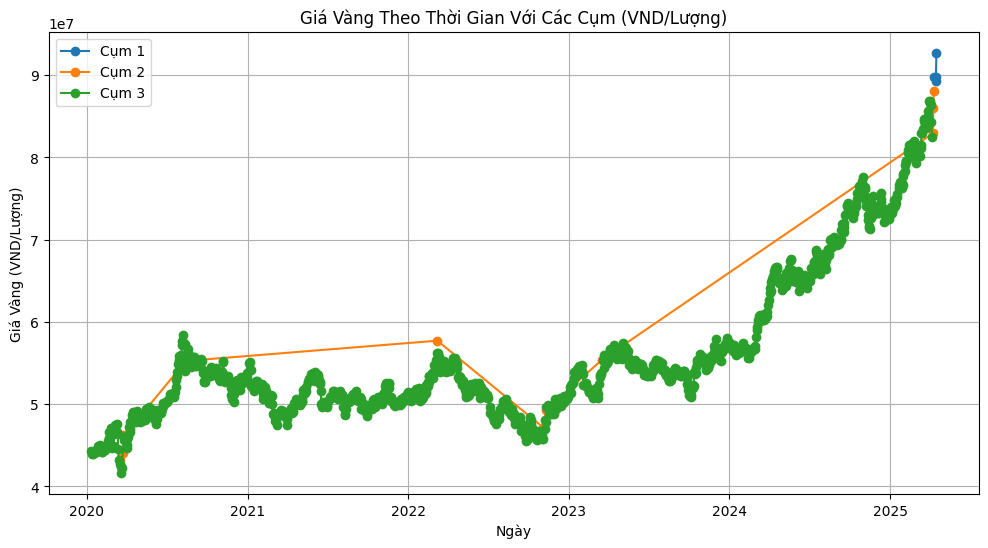

In [113]:
# 4. Vẽ biểu đồ giá vàng với các cụm
plt.figure(figsize=(12, 6))
for cluster in np.unique(hierarchical_clusters):
    cluster_data = data[data['Cluster'] == cluster]
    plt.plot(cluster_data['Date'], cluster_data['Gold_Price_VND_per_Luong'], label=f'Cụm {cluster}', marker='o', linestyle='-')
plt.title('Giá Vàng Theo Thời Gian Với Các Cụm (VND/Lượng)')
plt.xlabel('Ngày')
plt.ylabel('Giá Vàng (VND/Lượng)')
plt.legend()
plt.grid(True)
plt.show()

- Trên biểu đồ bạn cung cấp, trục Y được ghi nhãn là "Giá vàng (VND/Lượng)", và các giá trị trên trục Y là 4, 5, 6, 7, 8, 9. 
- Tuy nhiên, các giá trị này được biểu diễn với định dạng khoa học (scientific notation), vì ở góc trên cùng bên trái của trục Y có ghi "1e7", Điều này có nghĩa là các giá trị trên trục Y cần được nhân với 10^7 (10 triệu VNĐ) để ra giá trị thực tế.

* 4×10^7 = 40,000,000 VND/lượng
* 5×10^7 = 50,000,000 VND/lượng
* 6×10^7 = 60,000,000 VND/lượng
* 7×10^7 = 70,000,000 VND/lượng
* 8×10^7 = 80,000,000 VND/lượng
* 9×10^7 = 80,000,000 VND/lượng

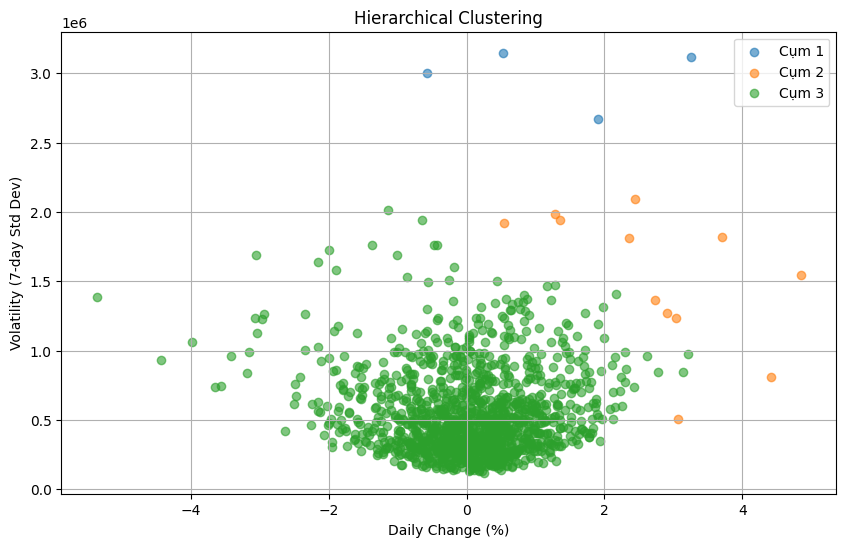

In [114]:
# Scatter plot theo cụm của Daily_Change và Volatility
plt.figure(figsize=(10, 6))
for cluster in np.unique(hierarchical_clusters):
    cluster_data = data[data['Cluster'] == cluster]
    plt.scatter(cluster_data['Daily_Change'], cluster_data['Volatility'], label=f'Cụm {cluster}', alpha=0.6)
plt.title('Hierarchical Clustering')
plt.xlabel('Daily Change (%)')
plt.ylabel('Volatility (7-day Std Dev)')
plt.legend()
plt.grid(True)

In [115]:
# Hiển thị thông tin các cụm
print("Thông tin các cụm:")
for cluster in np.unique(hierarchical_clusters):
    cluster_data = data[data['Cluster'] == cluster]
    print(f"Cụm {cluster}: {len(cluster_data)} ngày, Biến động trung bình: {cluster_data['Volatility'].mean():.2f}, Thay đổi trung bình: {cluster_data['Daily_Change'].mean():.2f}%")

Thông tin các cụm:
Cụm 1: 4 ngày, Biến động trung bình: 2985303.75, Thay đổi trung bình: 1.28%
Cụm 2: 12 ngày, Biến động trung bình: 1526407.06, Thay đổi trung bình: 2.73%
Cụm 3: 1308 ngày, Biến động trung bình: 540793.29, Thay đổi trung bình: 0.03%


# Áp dụng K-Means Clustering

In [116]:
# Chọn số cụm
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_clusters = kmeans.fit_predict(X_scaled)
data['KMeans_Cluster'] = kmeans_clusters + 1  # +1 để nhãn cụm bắt đầu từ 1

# Đánh giá hiệu suất giữa Hierarchical Cluster và K-Means Clustering

In [133]:
# Silhouette Score (càng cao càng tốt, từ -1 đến 1)
hierarchical_silhouette = silhouette_score(X_scaled, hierarchical_clusters)
kmeans_silhouette = silhouette_score(X_scaled, kmeans_clusters)

# Davies-Bouldin Index (càng thấp càng tốt)
hierarchical_db = davies_bouldin_score(X_scaled, hierarchical_clusters)
kmeans_db = davies_bouldin_score(X_scaled, kmeans_clusters)

print("So sánh hiệu suất:")
print("- Silhouette Score càng cao càng tốt, từ -1 đến 1")
print(f"\t + Silhouette Score (Hierarchical): {hierarchical_silhouette:.4f}")
print(f"\t + Silhouette Score (K-Means): {kmeans_silhouette:.4f}")
print("- Davies-Bouldin càng thấp càng tốt")
print(f"\t + Davies-Bouldin Index (Hierarchical): {hierarchical_db:.4f}")
print(f"\t + Davies-Bouldin Index (K-Means): {kmeans_db:.4f}")

So sánh hiệu suất:
- Silhouette Score càng cao càng tốt, từ -1 đến 1
	 + Silhouette Score (Hierarchical): 0.6239
	 + Silhouette Score (K-Means): 0.3768
- Davies-Bouldin càng thấp càng tốt
	 + Davies-Bouldin Index (Hierarchical): 0.7045
	 + Davies-Bouldin Index (K-Means): 0.9244


# 5. Vẽ biểu đồ giá vàng với các cụm (K-Means)

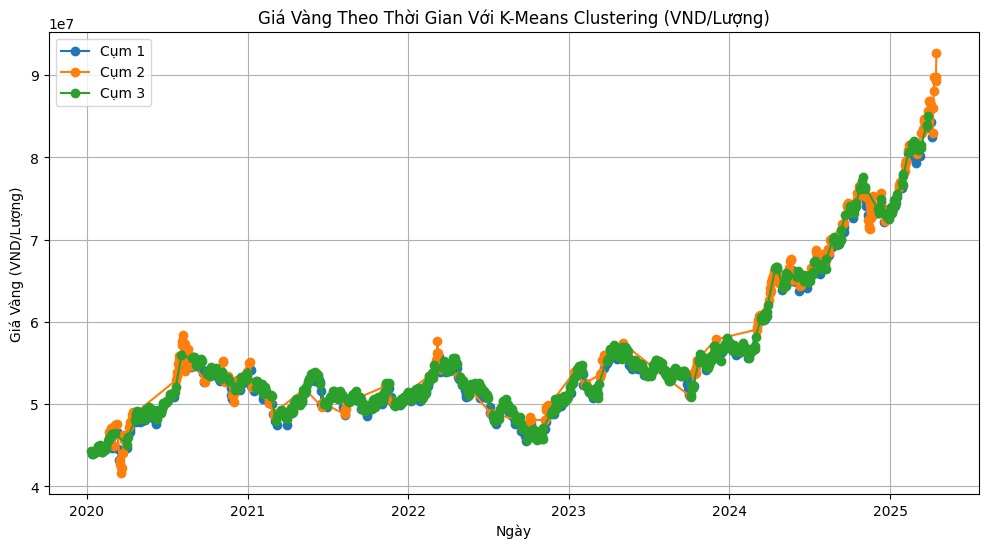

In [127]:
plt.figure(figsize=(12, 6))
for cluster in np.unique(kmeans_clusters + 1):
    cluster_data = data[data['KMeans_Cluster'] == cluster]
    plt.plot(cluster_data['Date'], cluster_data['Gold_Price_VND_per_Luong'], label=f'Cụm {cluster}', marker='o', linestyle='-')
plt.title('Giá Vàng Theo Thời Gian Với K-Means Clustering (VND/Lượng)')
plt.xlabel('Ngày')
plt.ylabel('Giá Vàng (VND/Lượng)')
plt.legend()
plt.grid(True)
plt.show()

# 6. Vẽ scatter plot so sánh giữa Hierarchical Clustering và K-Means Clustering

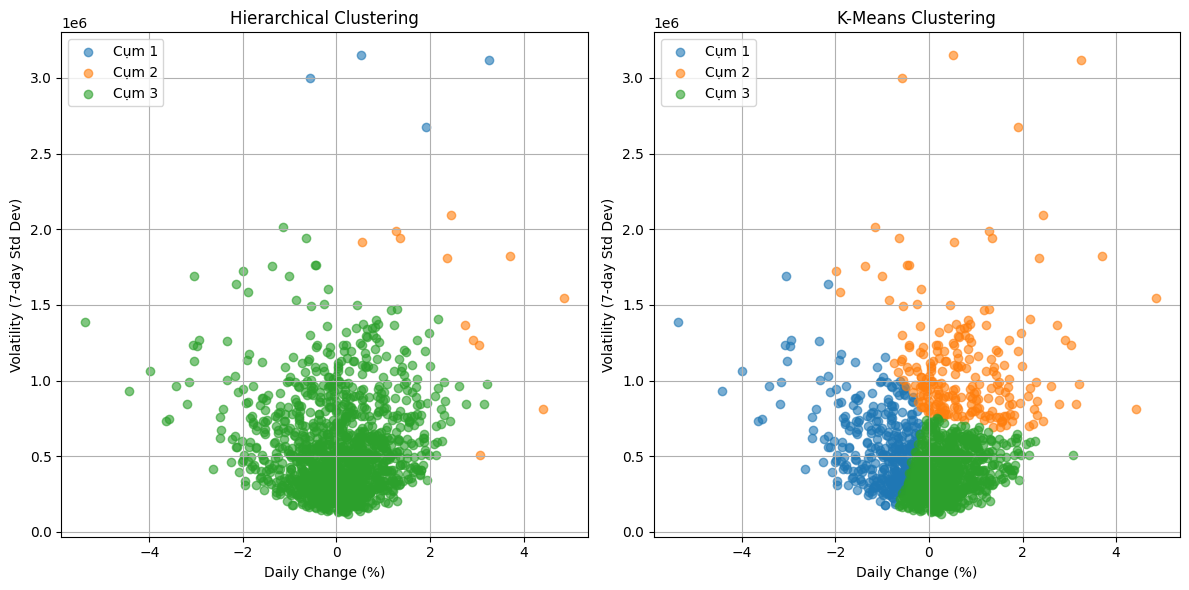

**Nếu bạn muốn thử số cụm khác, thay đổi t=3 (Hierarchical) và n_clusters=3 (K-Means). Để chọn số cụm tối ưu cho K-Means, bạn có thể thêm Elbow Method để tham khảo như bên dưới**


In [130]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for cluster in np.unique(hierarchical_clusters):
    cluster_data = data[data['Cluster'] == cluster]
    plt.scatter(cluster_data['Daily_Change'], cluster_data['Volatility'], label=f'Cụm {cluster}', alpha=0.6)
plt.title('Hierarchical Clustering')
plt.xlabel('Daily Change (%)')
plt.ylabel('Volatility (7-day Std Dev)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for cluster in np.unique(kmeans_clusters + 1):
    cluster_data = data[data['KMeans_Cluster'] == cluster]
    plt.scatter(cluster_data['Daily_Change'], cluster_data['Volatility'], label=f'Cụm {cluster}', alpha=0.6)
plt.title('K-Means Clustering')
plt.xlabel('Daily Change (%)')
plt.ylabel('Volatility (7-day Std Dev)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("**Nếu bạn muốn thử số cụm khác, thay đổi t=3 (Hierarchical) và n_clusters=3 (K-Means). Để chọn số cụm tối ưu cho K-Means, bạn có thể thêm Elbow Method để tham khảo như bên dưới**")

# Elbow Method cho K-Means

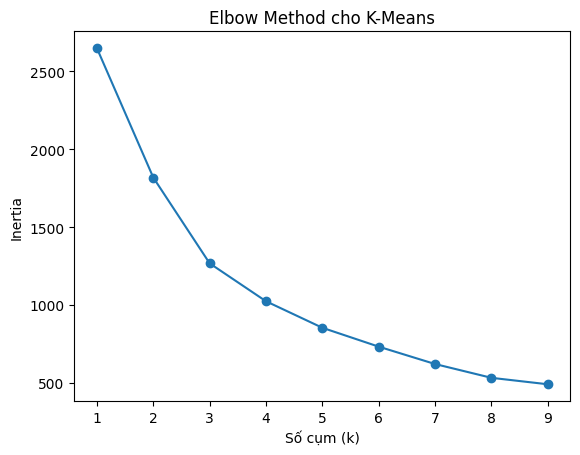

In [131]:
inertias = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
plt.plot(range(1, 10), inertias, marker='o')
plt.title('Elbow Method cho K-Means')
plt.xlabel('Số cụm (k)')
plt.ylabel('Inertia')
plt.show()

**Giải thích từng phần**
1. Chuẩn bị dữ liệu
    * Dữ liệu giá vàng được tải từ Yahoo Finance (GLD), quy đổi sang VND/lượng.
    * Tính hai đặc trưng: Daily_Change (% thay đổi giá hàng ngày) và Volatility (độ lệch chuẩn 7 ngày).
2. Áp dụng Hierarchical Clustering
    * Sử dụng linkage với phương pháp average và chia thành 3 cụm bằng fcluster
3. Áp dụng K-Means Clustering:
    * Sử dụng KMeans từ sklearn với k=3, random_state=42 để đảm bảo kết quả có thể tái lập.
4. Đánh giá hiệu suất
    * Silhouette Score: Đo lường mức độ tách biệt giữa các cụm (giá trị từ -1 đến 1, càng cao càng tốt).
    * Davies-Bouldin Index: Đo lường tỷ lệ giữa độ phân tán trong cụm và khoảng cách giữa các cụm (càng thấp càng tốt).
5. Trực quan hóa:
    * Vẽ biểu đồ giá vàng theo thời gian với các cụm từ cả hai phương pháp.
    * Vẽ scatter plot để so sánh cách các điểm dữ liệu được phân cụm.
6. So sánh hiệu suất (dự kiến)
    - Silhouette Score
    * Nếu K-Means có điểm cao hơn, điều này cho thấy các cụm được phân tách tốt hơn, vì K-Means tối ưu hóa trực tiếp khoảng cách đến tâm cụm.
    * Hierarchical Clustering có thể có điểm thấp hơn nếu dữ liệu không có cấu trúc cụm rõ ràng (do nó dựa trên khoảng cách liên kết).
    - Davies-Bouldin Index
    * K-Means thường cho chỉ số thấp hơn (tốt hơn) nếu dữ liệu có dạng hình cầu (spherical), vì K-Means giả định các cụm có hình dạng này.
    * Hierarchical Clustering có thể hoạt động tốt hơn nếu dữ liệu có cấu trúc phức tạp hơn (ví dụ: cụm không hình cầu).
7. So sánh thực tế
    - Tốc độ
    * K-Means nhanh hơn (độ phức tạp O(n*k*i) với 𝑘 k là số cụm, 𝑖 i là số lần lặp).
    * Hierarchical Clustering chậm hơn (độ phức tạp 𝑂 ( 𝑛^2 ) O(n^2 ) hoặc 𝑂 ( 𝑛^3 ) O(n^3 ) tùy phương pháp liên kết).
    - Tính linh hoạt
    * Hierarchical Clustering không cần xác định trước số cụm và cung cấp dendrogram để trực quan hóa.
    * K-Means yêu cầu chọn k trước, nhưng có thể dùng phương pháp như Elbow Method để xác định k.
8. Kết quả
    * Trong biểu đồ giá vàng, nếu các cụm từ Hierarchical Clustering và K-Means có sự khác biệt lớn, điều này cho thấy dữ liệu có thể không phù hợp với giả định của * K-Means (cụm hình cầu). Scatter plot sẽ giúp bạn thấy rõ cách hai phương pháp phân cụm khác nhau.